# 3’-isoform with clustQTL

Author: Aaron Brooks

July 8, 2015
Converted to iPython notebook on September 27, 2016

Example doc for detection of 3’-isoform QTLs with clustQTL.

In this example, I use 3’-isoform data for chr01, since that’s what is included with the clustQTL package.

In [25]:
library(clustQTL, 
        lib = "/Library/Frameworks/R.framework/Versions/3.3/Resources/library")
library(GenomicRanges)
library(ggbio)
library(pheatmap)
library(dplyr)

In [26]:
# load data sets
data(genotypes_yeast, package = "clustQTL")                        
data(markers_yeast, package = "clustQTL")                           
data(tx3_counts_chr01, package = "clustQTL")                        
data(tx_3utr_annotations_yeast_chr01, package = "clustQTL")
data(normCounts, package = "clustQTL")                     
data(rawCounts, package = "clustQTL")                     
data(tx_3utr, package = "clustQTL")                     

In [27]:
#gene = "YAL041W"
gene = "SUT433"
#gene = sample(names(tx_3utr_annotations_yeast_chr01),1)
x = subsetByOverlaps(tx3_counts_chr01,tx_3utr_annotations_yeast_chr01[gene])
data = t(granges2matrix(x))
# log transform
data = log2(data+1)
# need to clean up data names
rnames = sapply( sub("X","",sapply( rownames(data), function(i) strsplit(i,"_")[[1]][1] ) ), function(i) {
    if (nchar(i)==2){ 
        i = paste("0",i,sep="")
    } 
    i
} )
rownames(data) = rnames
# remove insig peaks
peak_cutoff = find_sigCounts( data )
data_o = data
data[ , colSums(data)<peak_cutoff ] = 0

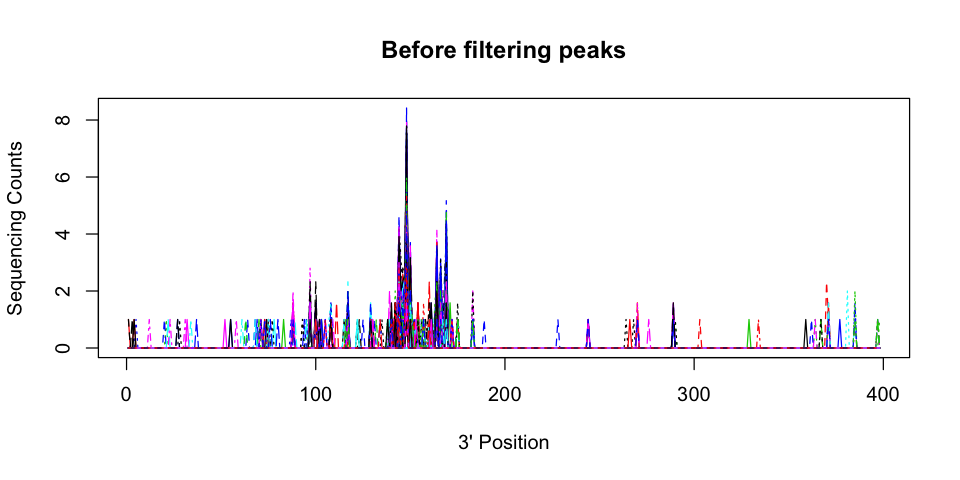

In [28]:
options(repr.plot.width = 8)
options(repr.plot.height = 4)
matplot(t(data_o),type="l",main="Before filtering peaks",
        xlab="3' Position",ylab="Sequencing Counts")

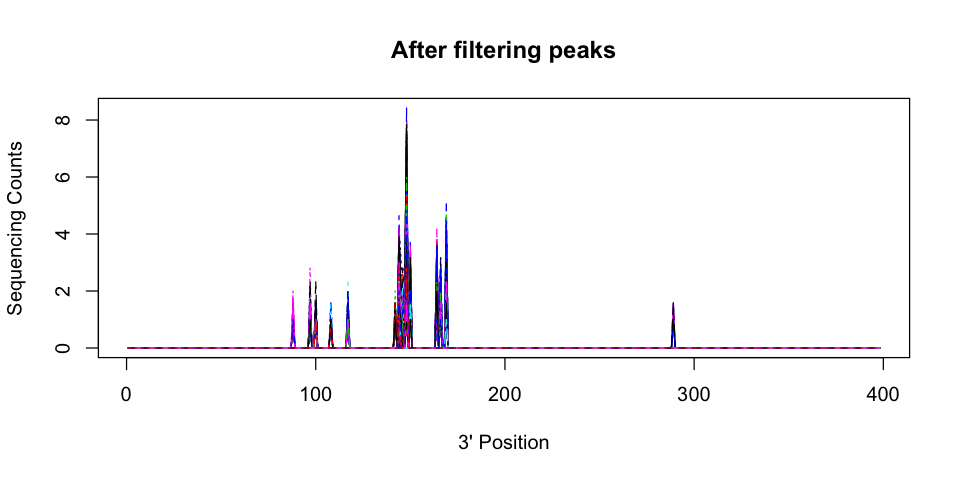

In [29]:
matplot(t(data),type="l",main="After filtering peaks",
        xlab="3' Position",ylab="Sequencing Counts")

In [30]:
data = data[rownames(data)%in%colnames(genotypes_yeast),]
clust_qtl = clustANDscore(data,genotypes_yeast,distance="cosine")

Warning message:
In plot.window(...): "show" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "show" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): "show" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): "show" is not a graphical parameterWarning message:
In box(...): "show" is not a graphical parameterWarning message:
In title(...): "show" is not a graphical parameterWarning message:
In axis(1, at = ticks, labels = labs, ...): "show" is not a graphical parameterWarning message:
In plot.xy(xy.coords(x, y), type = type, ...): "show" is not a graphical parameterWarning message:
In plot.xy(xy.coords(x, y), type = type, ...): "show" is not a graphical parameterWarning message:
In plot.xy(xy.coords(x, y), type = type, ...): "show" is not a graphical parameterWarning message:
In plot.xy(xy.coords(x, y), type = type, ...): "show" is not a graphical parameterWarning messag

NULL

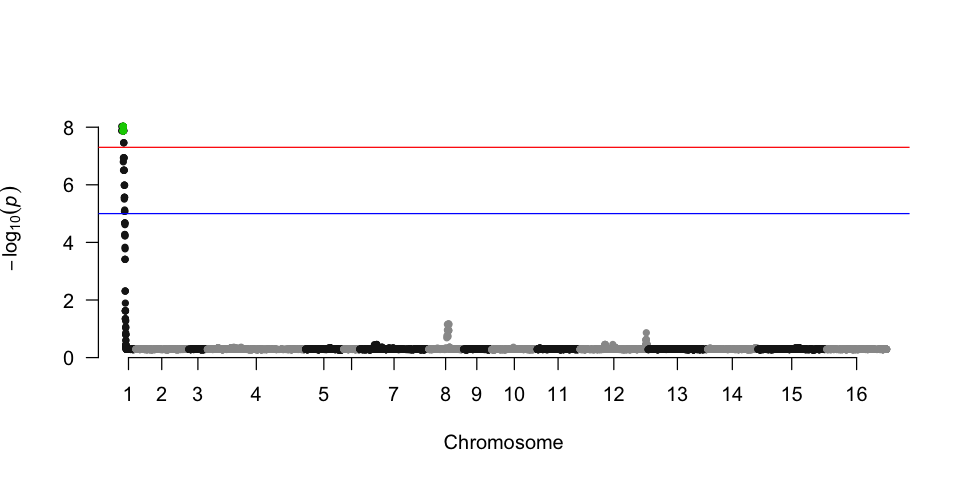

In [31]:
plotManhattan(clust_qtl,markers_yeast, 
              gene,trx_annot=tx_3utr_annotations_yeast_chr01)

In [33]:
peaks = findQTLPeaks(clust_qtl,markers_yeast)

peak_genotypes = do.call(rbind,lapply(names(peaks),function(i){getGenotypes(i,genotypes_yeast)}))
rownames(peak_genotypes) = names(peaks)

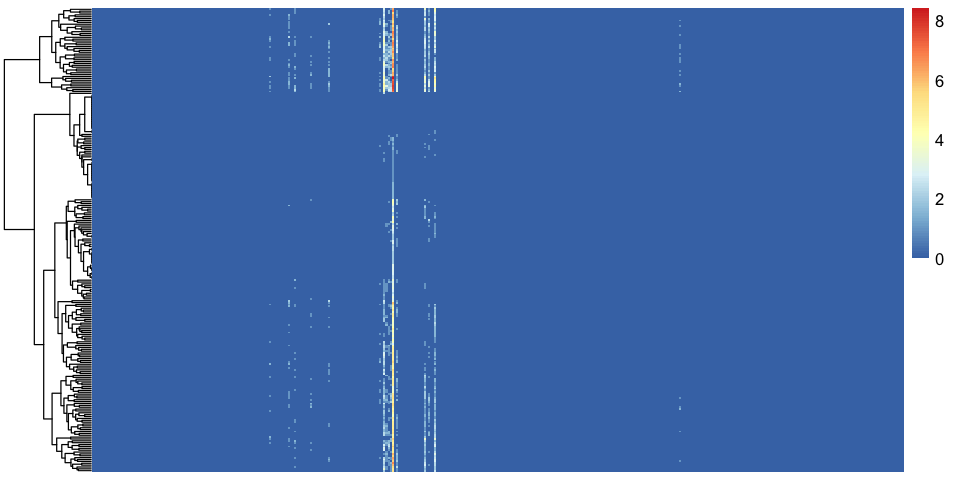

In [32]:
pheatmap::pheatmap(data, show_rownames = F, show_colnames = F, cluster_cols = F)

In [34]:
x = 1

A = names(which(peak_genotypes[x,] == 1))
A = intersect( A, rownames(data) )
B = names(which(peak_genotypes[x,] == 2))
B = intersect( B, rownames(data) )

# correlation
all_cor = cor(t(data[c(A,B),]),use="pair",method="pearson")
in_a = all_cor[A,A]
in_b = all_cor[B,B]
out_ab = all_cor[A,B]
out_ba = all_cor[B,A]

mean(in_a[upper.tri(in_a)],na.rm=T)
mean(in_b[upper.tri(in_b)],na.rm=T)
mean(out_ab[upper.tri(out_ab)],na.rm=T)
mean(out_ba[upper.tri(out_ba)],na.rm=T)

data = data[which(apply(data,1,sum)>0,useNames=T),]

Warning message:
In cor(t(data[c(A, B), ]), use = "pair", method = "pearson"): the standard deviation is zero

[1] 0.7545224

[1] 0.8474565

[1] 0.7528748

[1] 0.7738825

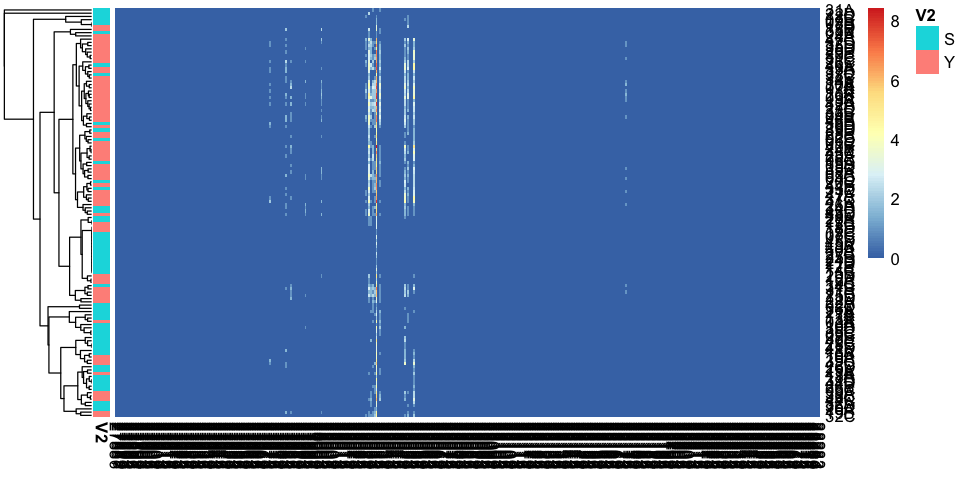

In [35]:
pheatmap(data[c(A,B),],
         cluster_cols=F,
         clustering_distance_rows=as.dist(cosineDist(data[c(A,B),])),
         scale="none",annotation_row=data.frame(rbind(cbind(A,"S"),
          cbind(B,"Y")),row.names=1))